## Loading and using a trained model for Fashion
Notebook demonstrating how to load a JointVAE model and use it for various things.

In [1]:
from utils.load_model import load

path_to_model_folder = './trained_models/fashion/'

model = load(path_to_model_folder)

In [2]:
# Print the latent distribution info
print(model.latent_spec)

{'disc': [10], 'cont': 10}


In [3]:
# Print model architecture
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=10, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv

In [4]:
from viz.visualize import Visualizer as Viz

# Create a Visualizer for the model
viz = Viz(model)
viz.save_images = False  # Return tensors instead of saving images

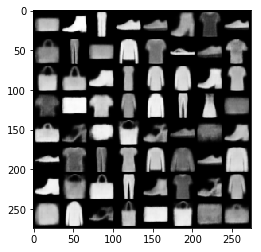

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

samples = viz.samples()
plt.imshow(samples.numpy()[0, :, :], cmap='gray')

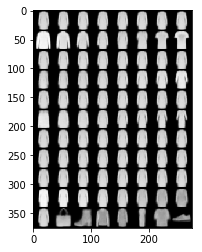

In [8]:
traversals = viz.all_latent_traversals()
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

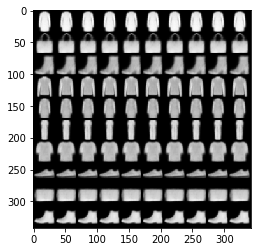

In [9]:
# Traverse 3rd continuous latent dimension across columns and first 
# discrete latent dimension across rows
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

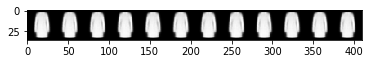

In [17]:
traversal = viz.latent_traversal_line(cont_idx=7, size=12)
plt.imshow(traversal.numpy()[0, :, :], cmap='gray')

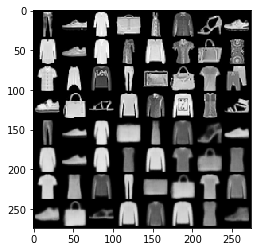

In [14]:
from utils.dataloaders import get_fashion_mnist_dataloaders

# Get MNIST test data
_, dataloader = get_fashion_mnist_dataloaders(batch_size=32)

# Extract a batch of data
for batch, labels in dataloader:
    break
    
recon = viz.reconstructions(batch, size=(8, 8))

plt.imshow(recon.numpy()[0, :, :], cmap='gray')

In [15]:
from torch.autograd import Variable
encodings = model.encode(Variable(batch))

In [16]:
# Continuous encodings for the first 5 examples
encodings['cont'][0][:5]

tensor([[ 0.0172, -0.6644,  0.0836,  1.3985, -0.0094, -0.1781, -0.0477, -0.0387,
          0.0067, -0.1019],
        [ 0.0231, -0.8522,  0.0449, -0.3266, -0.0035, -0.3624, -0.0455, -0.0350,
         -0.0205, -0.4873],
        [ 0.0362,  0.0283,  0.0553,  0.7656, -0.0231,  0.3806, -0.0946, -0.0453,
         -0.0340, -0.9279],
        [-0.0109, -1.1826,  0.0750, -0.4624, -0.0430,  0.4721, -0.0596, -0.0431,
         -0.0081,  0.5363],
        [ 0.0050,  0.8565,  0.0165,  0.6498, -0.0109, -0.0517, -0.0465, -0.0146,
         -0.0080,  0.8183]], grad_fn=<SliceBackward>)

In [19]:
# Plot a grid of some traversals
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch
path_to_data='../fashion_data'
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
test_data = datasets.FashionMNIST(path_to_data, train=False,
                               transform=all_transforms)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
for data in test_loader:
    pass
imges = data[0]
label = data[1]

In [20]:
latent_dist = model.encode(imges)
_, predict_label = torch.max(latent_dist['disc'][0], dim=1)
confusion = torch.zeros(10, 10)
for i in range(10000):
    confusion[label[i].item(),predict_label[i].item()] += 1
for i in range(10):
    confusion[i] = confusion[i] / confusion[i].sum()

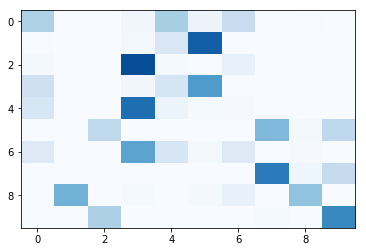

In [21]:
# confusion = np.array([[0.9,0.1,0.0],[0.0,0.8,0.2],[0.1,0.7,0.2]])
# confusion = torch.tensor(confusion)
from matplotlib import cm
plt.imshow(confusion,interpolation='nearest',cmap=cm.Blues,aspect='auto',vmin=0,vmax=1.0)

In [22]:
value, predict_label = torch.max(confusion, dim=1)

In [23]:
list_price_positoin_address = []
seen = []
for i in predict_label:
    if i in seen:
        pass
    else:
        seen.append(i)
        address_index = [x for x in range(len(predict_label)) if predict_label[x] == i]
        list_price_positoin_address.append([i, address_index])
dict_address = dict(list_price_positoin_address)
print(dict_address)

{tensor(4): [0], tensor(5): [1, 3], tensor(3): [2, 4, 6], tensor(7): [5, 7], tensor(1): [8], tensor(9): [9]}


In [24]:
for keys in dict_address.keys():
    if(len(dict_address[keys])>1):
        acc = confusion[dict_address[keys],keys.item()]
        _, predict_label = torch.min(acc, dim=0)
        confusion[dict_address[keys][predict_label.item()],keys.item()] = 0.0
        value[dict_address[keys][predict_label.item()]], p = torch.max(confusion[dict_address[keys][predict_label.item()],:],dim=0)

In [25]:
value.mean()

tensor(0.5293)